Testing

In [1]:
import networkx as nx
import osmnx as ox
import matplotlib

In [2]:
# location = ox.geocoder.geocode("Primero Grove Apartments")
# bikeGraph = ox.graph.graph_from_point(location, dist=500, network_type='bike')
# fig, ax = ox.plot.plot_graph(bikeGraph)

# # Save the graph for offline access
# ox.io.save_graphml(bikeGraph, "bikeGraph.graphml")

In [3]:
# location = ox.geocoder.geocode("Primero Grove Apartments")
# bikeGraph = ox.graph.graph_from_point(location, dist=500, network_type='bike')
# fig, ax = ox.plot.plot_graph(bikeGraph)

# # Save the graph for offline access
# ox.io.save_graphml(bikeGraph, "bikeGraph.graphml")

In [4]:
bikeGraph = ox.io.load_graphml("bikeGraph.graphml")

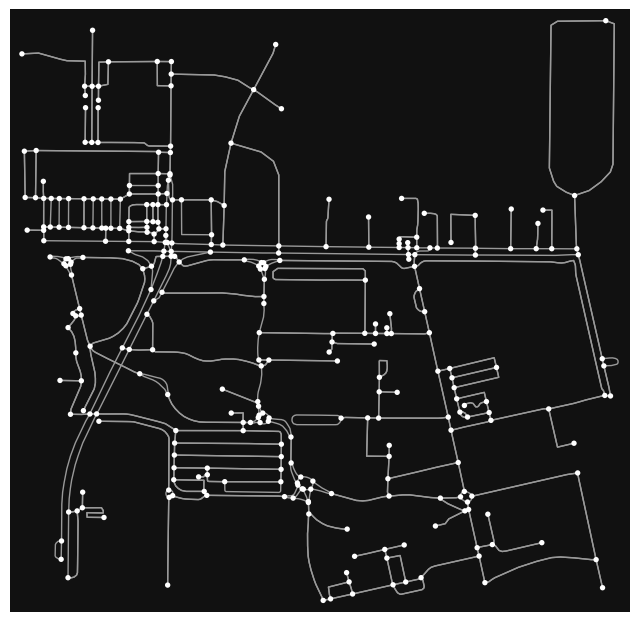

In [5]:
fig, ax = ox.plot.plot_graph(bikeGraph)

In [6]:
bikeGraph = ox.routing.add_edge_speeds(bikeGraph)
bikeGraph = ox.routing.add_edge_travel_times(bikeGraph)

In [7]:
ox.stats.basic_stats(bikeGraph)

{'n': 313,
 'm': 715,
 'k_avg': 4.568690095846645,
 'edge_length_total': 36778.962803720104,
 'edge_length_avg': 51.43910881639175,
 'streets_per_node_avg': 2.840255591054313,
 'streets_per_node_counts': {0: 0, 1: 42, 2: 5, 3: 229, 4: 36, 5: 0, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.134185303514377,
  2: 0.01597444089456869,
  3: 0.731629392971246,
  4: 0.11501597444089456,
  5: 0.0,
  6: 0.003194888178913738},
 'intersection_count': 271,
 'street_length_total': 21221.371937211363,
 'street_segment_count': 429,
 'street_length_avg': 49.46706745270714,
 'circuity_avg': 1.0896692141336908,
 'self_loop_proportion': 0.006993006993006993}

In [8]:
bikeGraph_gdf = ox.graph_to_gdfs(bikeGraph)

In [9]:
points = bikeGraph_gdf[0]
points

,y,x,street_count,highway,geometry
osmid,,,,,
95705399,38.544699,-121.760569,3,NaN,POINT (-121.76057 38.5447)
95708589,38.545005,-121.753711,3,NaN,POINT (-121.75371 38.54501)
95708590,38.544994,-121.755583,3,NaN,POINT (-121.75558 38.54499)
95710346,38.543768,-121.760673,3,NaN,POINT (-121.76067 38.54377)
95714492,38.546335,-121.757717,3,NaN,POINT (-121.75772 38.54634)
...,...,...,...,...,...
12048790068,38.546280,-121.751639,3,NaN,POINT (-121.75164 38.54628)
12048924771,38.546663,-121.751605,1,NaN,POINT (-121.75161 38.54666)
12345024863,38.543726,-121.752971,3,NaN,POINT (-121.75297 38.54373)


In [10]:
edges = bikeGraph_gdf[1]
edges

osmid  highway maxspeed  \
u           v           key                                              
95705399    95714523    0                   10746002  service   10 mph   
            4081602827  0                   10746002  service   10 mph   
95708589    481972235   0                  585913691  service   25 mph   
            11230070177 0                  585913691  service   25 mph   
            9172280461  0                   10745154  service   25 mph   
...                                              ...      ...      ...   
12345024863 12345024866 1                 1334374443  service      NaN   
12345024866 481972231   0                   40052692  service   10 mph   
            12345024863 0                   40052692  service   10 mph   
                        1                 1334374443  service      NaN   
13010044540 559373759   0    [254986477, 1415750885]  service      NaN   

                                            name  oneway reversed      length  \
u           v           key                                                     
95705399    95714523    0         Parkway Circle   False    False   46.116046   
            4081602827  0         Parkway Circle   False     True   48.484485   
95708589    481972235   0      California Avenue   False    False   66.406794   
            11230070177 0      California Avenue   False     True   36.334412   
            9172280461  0    Beckett Hall Circle   False    False   64.458271   
...                                          ...     ...      ...         ...   
12345024863 12345024866 1                    NaN   False    False   17.254335   
12345024866 481972231   0                    NaN   False     True   23.032651   
            12345024863 0                    NaN   False    False   17.917231   
                        1                    NaN   False     True   17.254335   
13010044540 559373759   0                    NaN   False     True  105.796553   

                                                                      geometry  \
u           v           key                                                      
95705399    95714523    0    LINESTRING (-121.76057 38.5447, -121.76057 38....   
            4081602827  0    LINESTRING (-121.76057 38.5447, -121.76057 38....   
95708589    481972235   0    LINESTRING (-121.75371 38.54501, -121.75355 38...   
            11230070177 0    LINESTRING (-121.75371 38.54501, -121.7538 38....   
            9172280461  0    LINESTRING (-121.75371 38.54501, -121.75379 38...   
...                                                                        ...   
12345024863 12345024866 1    LINESTRING (-121.75297 38.54373, -121.75302 38...   
12345024866 481972231   0    LINESTRING (-121.75312 38.5438, -121.75318 38....   
            12345024863 0    LINESTRING (-121.75312 38.5438, -121.75311 38....   
                        1    LINESTRING (-121.75312 38.5438, -121.75307 38....   
13010044540 559373759   0    LINESTRING (-121.76002 38.5422, -121.76035 38....   

                             speed_kph  travel_time lanes tunnel  \
u           v           key                                        
95705399    95714523    0     16.09340    10.315891   NaN    NaN   
            4081602827  0     16.09340    10.845697   NaN    NaN   
95708589    481972235   0     40.23350     5.941925   NaN    NaN   
            11230070177 0     40.23350     3.251119   NaN    NaN   
            9172280461  0     40.23350     5.767576   NaN    NaN   
...                                ...          ...   ...    ...   
12345024863 12345024866 1     22.60176     2.748264   NaN    NaN   
12345024866 481972231   0     16.09340     5.152270   NaN    NaN   
            12345024863 0     16.09340     4.007980   NaN    NaN   
                        1     22.60176     2.748264   NaN    NaN   
13010044540 559373759   0     22.60176    16.851236   NaN    NaN   

                                   service junction access  
u           v    

In [11]:
edges["service"]

u            v            key
95705399     95714523     0                NaN
             4081602827   0                NaN
95708589     481972235    0                NaN
             11230070177  0                NaN
             9172280461   0                NaN
                                     ...      
12345024863  12345024866  1      parking_aisle
12345024866  481972231    0      parking_aisle
             12345024863  0      parking_aisle
                          1      parking_aisle
13010044540  559373759    0           driveway
Name: service, Length: 715, dtype: object

# Clean bike network

In [12]:
edges['maxspeed'].dtype

dtype('O')

In [13]:
# Add traffic probability to edges

# Clean driving network

# Varying Time Budgets